In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
from datetime import datetime as dt
import pandas_market_calendars as mcal
import dateutil

In [4]:
# get range of dates from the last 100 days
import datetime
numdays = 100
# get current date
base = datetime.datetime.today()
# list comp for current date - number of days for range of dates
date_list = [base - datetime.timedelta(days=x) for x in range(numdays)]
# put into dataframe to do datetime formatting
dates = pd.DataFrame(date_list, columns = ['dates'])
dates['dates'] = pd.to_datetime(dates.dates)
dates['dates'] = dates['dates'].dt.strftime('%Y-%m-%d')
# sort dates ascending values
dates = dates.sort_values(by="dates", ascending=True)
# all dates are in a list to use in REST API to fetch data
dates = list(dates['dates'])

In [5]:
ticker = 'X:LINKUSD'
range_agg = '/range/1/day/'
unadjusted = 'unadjusted=true'
sort = '&sort=asc'
limit = '&limit=50000'
POLYGON_URL = 'https://api.polygon.io/v2/aggs/ticker/'
from_date = '2013-12-06'
to_date = '2021-07-25'
POLYGON_API = '&apiKey=x6XqEaDjOWJXwVQRyBQ5kMEi8KlCYZqo'

In [6]:
datetime = []
open_price = []
high_price = []
low_price = []
close_price = []
volume = []
#for date in dates:
polygon = POLYGON_URL + ticker + range_agg + from_date + '/' + to_date + '?' + unadjusted + sort + limit + POLYGON_API
r_polygon = requests.get(polygon)
polygon_response = r_polygon.json()
for aggs in range(len(polygon_response['results'])):
    datetime.append(dt.fromtimestamp(polygon_response['results'][aggs]['t']/ 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
    open_price.append(polygon_response['results'][aggs]['o'])
    high_price.append(polygon_response['results'][aggs]['h'])
    low_price.append(polygon_response['results'][aggs]['l'])
    close_price.append(polygon_response['results'][aggs]['c'])
    volume.append(polygon_response['results'][aggs]['v'])

In [7]:
df = pd.DataFrame(list(zip(datetime,open_price,high_price,low_price, close_price,volume)),
columns =['datetime', 'open', 'high', 'low', 'close', 'volume'])

In [8]:
df.head()

,datetime,open,high,low,close,volume
0,2019-06-27 00:00:00,2.80099,2.80099,2.05000,2.31980,3.079686e+05
1,2019-06-28 00:00:00,2.31980,3.60000,2.20000,3.18477,5.414270e+06
2,2019-06-29 00:00:00,3.18398,5.10000,2.92001,3.80123,2.656176e+07
3,2019-06-30 00:00:00,3.84892,4.24990,3.20101,3.41849,1.203341e+07
4,2019-07-01 00:00:00,3.38060,3.98880,2.83100,3.62996,1.231476e+07


In [9]:
len(df)

759

In [10]:
df['datetime']

0      2019-06-27 00:00:00
1      2019-06-28 00:00:00
2      2019-06-29 00:00:00
3      2019-06-30 00:00:00
4      2019-07-01 00:00:00
              ...         
754    2021-07-21 00:00:00
755    2021-07-22 00:00:00
756    2021-07-23 00:00:00
757    2021-07-24 00:00:00
758    2021-07-25 00:00:00
Name: datetime, Length: 759, dtype: object

In [11]:
df.describe()

,open,high,low,close,volume
count,759.000000,759.000000,759.000000,759.000000,7.590000e+02
mean,11.487192,12.198273,10.670890,11.507946,4.078690e+06
std,11.189228,11.877194,10.287813,11.191959,3.256669e+06
min,1.570000,1.638000,1.392450,1.569980,3.079686e+05
25%,2.656560,2.767410,2.527680,2.657470,1.953381e+06
50%,6.096540,6.990000,5.711830,6.146060,3.149794e+06
75%,16.611895,17.571865,15.235000,16.742065,5.046127e+06
max,52.320300,53.000000,46.417870,52.339840,2.656176e+07


In [12]:
# Select only the important features i.e. the date and price
data = df[["datetime","close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
data = data.rename(columns = {"datetime":"ds","close":"y"}) #renaming the columns of the dataset
data.tail(5)

,ds,y
754,2021-07-21 00:00:00,15.29500
755,2021-07-22 00:00:00,16.08147
756,2021-07-23 00:00:00,16.52000
757,2021-07-24 00:00:00,16.70370
758,2021-07-25 00:00:00,16.78043


In [13]:
from prophet import Prophet
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(data) # fit the model using all data

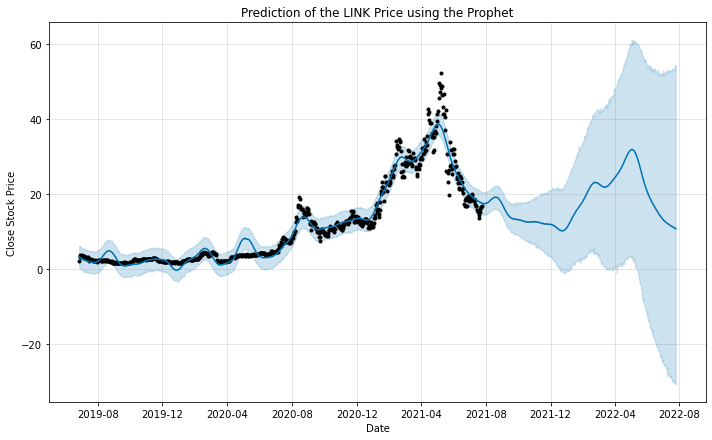

In [14]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the LINK Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

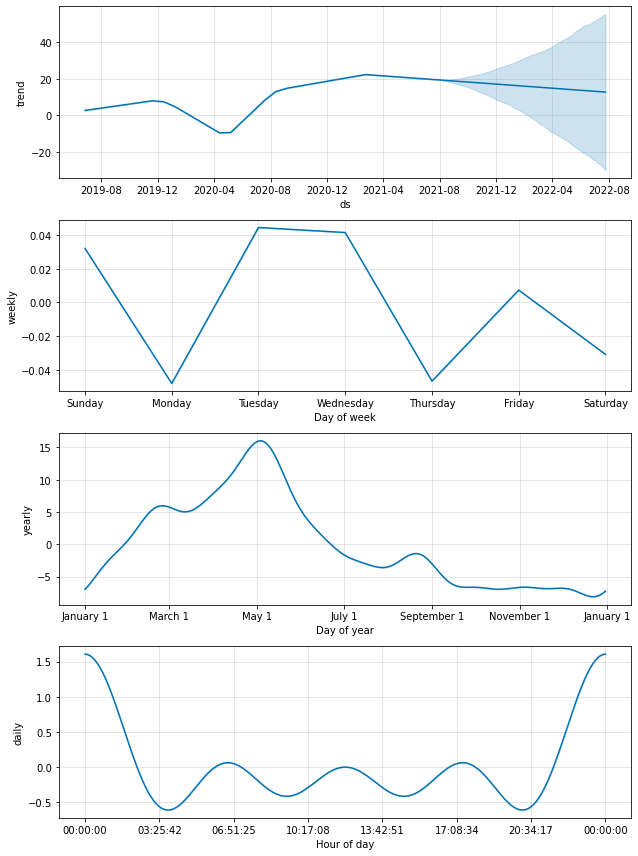

In [15]:
m.plot_components(prediction)
plt.show()

In [14]:
# try with some hyperparameter tuning
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation, performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 41 forecasts with cutoffs between 2019-09-28 00:00:00 and 2021-05-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7e42bb5cd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 41 forecasts with cutoffs between 2019-09-28 00:00:00 and 2021-05-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7e41379590>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasona

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  7.065278
1                     0.001                     0.10  7.075003
2                     0.001                     1.00  7.068001
3                     0.001                    10.00  7.070567
4                     0.010                     0.01  5.396278
5                     0.010                     0.10  5.412326
6                     0.010                     1.00  5.400660
7                     0.010                    10.00  5.408348
8                     0.100                     0.01  5.483696
9                     0.100                     0.10  5.474624
10                    0.100                     1.00  5.476852
11                    0.100                    10.00  5.477126
12                    0.500                     0.01  5.404942
13                    0.500                     0.10  5.405292
14                    0.500                     1.00  5

In [32]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


In [33]:
m = Prophet(daily_seasonality = True, changepoint_prior_scale=0.1, seasonality_prior_scale=0.1) # the Prophet class (model)
m.fit(data)

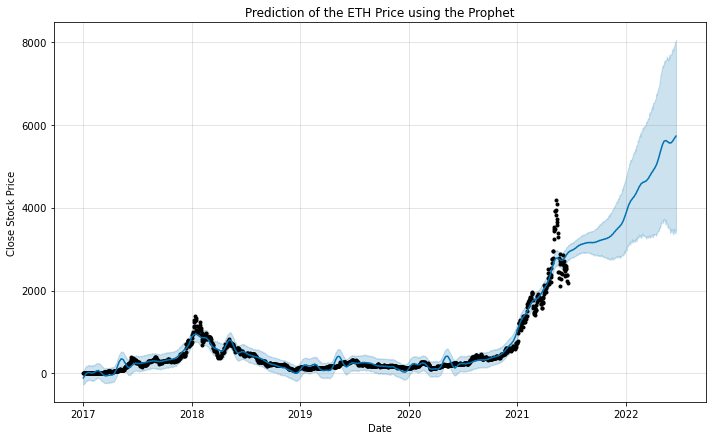

In [34]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the LINK Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

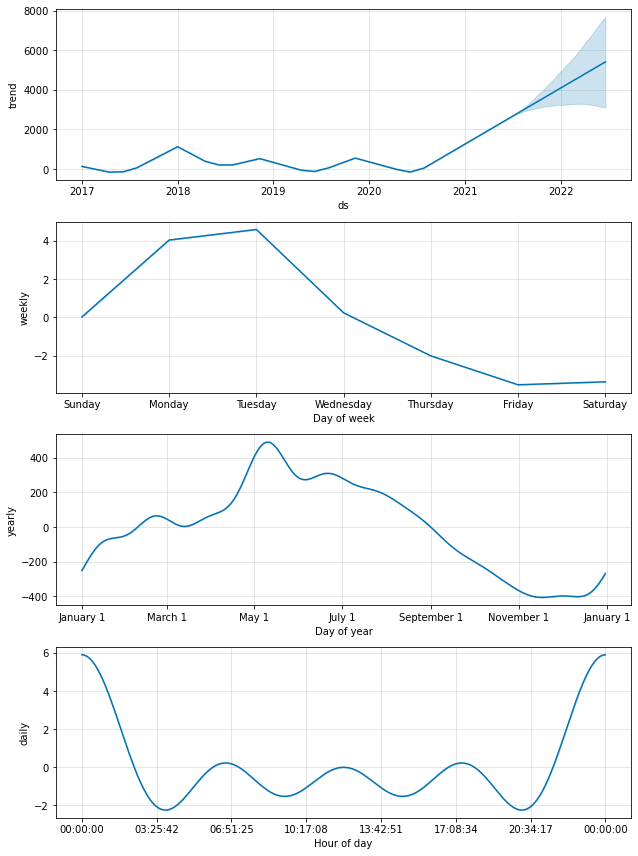

In [35]:
m.plot_components(prediction)
plt.show()